# Scan Chain Insertion

Scan chains are used in Design-For-Test procedures in digital circuits.
Flip-Flops are connected in a serial chain so their internal states can be shifted in and out for testing.
During the test mode, normal data paths are bypassed, allowing test patterns to be loaded into the flip-flops and the resulting states to be read back.
This improves fault detection and makes automated testing of complex ICs far more efficient.
This notebook shows step-by-step how a scan chain can be implemented into a circuit.
See [the wikipedia page for Scan Chains](https://en.wikipedia.org/wiki/Scan_chain) for more information.

## Reading the design file
For this example, a circuit file (`files/dff_circuit.v`) is provided, which contains several nested modules with different types of D-Flipflops (i.e. some have an asynchronous reset, or an enable port, while other's don't).
The top module of the circuit is simply called `Top`.

For simplicity, the individual components and functions of the scan chain insertion algorithm are presented and explained first.

In [1]:
import netlist_carpentry

c = netlist_carpentry.read(["../../files/dff_circuit.v", ], top="Top")

## Rough Roadmap
The goal is to have a long chain of Scan-Flipflops, that can be put into scan mode via an enable signal (forwarded through a "Shift-Enable" port), where values can be shifted in and out of the chain via dedicated "Shift-In" and "Shift-Out" Ports.
For a hierarchically structured circuit, this must be done for each module.
Accordingly, the first step is to add the three ports to the module.

In [2]:
from netlist_carpentry import LOG, Direction, Module


def create_scan_ports(m: Module):
    m.create_port("SE", Direction.IN)
    m.create_port("SI", Direction.IN)
    m.create_port("SO", Direction.OUT)
    m.update_module_instances()  # All instances of module m are now updated to receive the 3 ports as well
    LOG.debug(f"Created scan ports in module {m.name}!")

## Collecting and replacing Flip-Flops with their Scan Counterparts

Before the actual replacement, n-bit wide Flip-Flops must be split into n 1-bit wide Flip-Flops.
Otherwise, the Shift-Chain cannot be created, as there would be ports of different widths in the chain.
This can be done with `Module.split_all(instance_type)`, where `instance_type` is used to perform a fuzzy search, meaning that `Module.split_all("dff")` will also split Flip-Flops of type "adff", "dffe" and "adffe".

Now all Flip-Flops should be replaced with their Scan-Version.
The `DFF` class already provides a method `get_scanff`, which returns a copy of the current flip-flop, with the same parameters, but completely unconnected.
By calling `Module.replace(old_instance, new_instance)`, each Flip-Flop can be replaced with the appropriate Scan-DFF.
Execute the cell below to replace all normal Flip-Flops with Scan-Flip-Flops.

In [3]:
from typing import List

from netlist_carpentry.utils.gate_lib import DFF


def replace_ff_with_scan_ff(m: Module) -> List[DFF]:
    m.split_all("dff")
    dffs: List[DFF] = m.get_instances(type="dff", fuzzy=True)
    for dff in dffs:
        m.replace(dff, dff.get_scanff(), silent=True)
    return m.get_instances(type="dff", fuzzy=True) # These are the scan flip-flops just replaceds

## Recursively Implementing Scan Chains in Submodules

Each module may contain submodules, which in turn might have Flip-Flops or submodules.
These must be included into the scan chain as well.
This can be checked by iterating over all submodules via `Module.submodules` and checking if there are any instances with "dff" in their instance types, either in this submodule or lower submodules.
If any are found, go back to the top method (which is not defined yet, but will soon), but this time call it with the submodule.
Finally, return all instances, into whose module definition a scan chain was inserted.

In [4]:
from netlist_carpentry import Instance


def implement_scanff_in_submodules(m: Module) -> List[Instance]:
    sub_insts_with_dff = []
    for sub in m.submodules:
        # Check if there are flip-flops anywhere in this submodule
        dffs_in_submodule = sub.module_definition.get_instances(type="dff", fuzzy=True, recursive=True)
        if len(dffs_in_submodule) > 0:
            # This is the main method, which is now called with the submodule definition
            # The method itself is defined later for simplicity
            implement_scan_chain(sub.module_definition)
            sub_insts_with_dff.append(sub)
    return sub_insts_with_dff

## Connect all Scan-Flip-Flops and Submodules to a Scan Chain

Now that all Flip-Flops are replaced and each submodule received the Scan ports (if required), they must be connected.
The method in the cell below takes a list of the individual scan chain elements - how this list is created is shown later.
Each element is connected to the module "Scan-Enable" input port.
The actual "chaining" process is executed by `Module.make_chain`, which takes a list of elements to chain, as well as the names of the input and output ports, defining how the chain is connected (from output to input).
In this specific case, `Module.make_chain` connects each "SO" port to the next instance's "SI" port, and leaves the first "SI" and last "SO" unconnected.
These two ports must be connected manually, i.e. the module's "SI" port is connected to the first instance's "SI" port, and the last instance's "SO" port is connected to the module's "SO" port.

<div class="admonition info alert alert-info">
  <strong>Info:</strong> You can insert multiple chains by splitting the <b>list_of_scan_elements</b> list and calling the <b>connect_all_scan_elements</b> multiple times with the appropriate sub-chain.
  In such case, multiple scan-in and scan-out ports are required in the parent module, for each scan chain, e.g. "SI0", "SI1", "SI2" and "SO0", "SO1", "SO2".
  These port names must then be passed to the function as well, so each scan chain is connected to the correct module port.
</div>

In [5]:
def connect_all_scan_elements(m: Module, list_of_scan_elements: List[Instance], scan_in: str, scan_out: str, scan_enable: str):
    LOG.info(f"Scan Chain contains {len(list_of_scan_elements)} element(s) in module {m.name}!")
    for inst in list_of_scan_elements:
        # Connect the Scan-Enable port of the module to each scan chain element
        m.connect(m.ports[scan_enable], inst.ports[scan_enable])

    if list_of_scan_elements: # There is at least one element in the list
        m.connect(m.ports[scan_in], list_of_scan_elements[0].ports["SI"])
        m.make_chain(list_of_scan_elements, "SI", "SO")
        m.connect(list_of_scan_elements[-1].ports["SO"], m.ports[scan_out])

## Catching Corner Cases
Two corner cases are very likely occur:
1.  A module does not contain Flip-Flops, either directly or inside submodules.
2.  A module was modified previously and now a second instance of this module is being modified - the module definition must not be modified again.
    This case can be tracked via the module's metadata.
    If the module is receiving a scan chain, the corresponding metadata entry is set.
    If this module is encountered again, the metadata entry is present, indicating, that this module should not be modified again.

The method in the cell below catches both cases, indicating that this module should be skipped for one of both reasons.

In [6]:
def skip_module(m: Module) -> bool:
    if not m.get_instances(type="dff", fuzzy=True, recursive=True):
        LOG.info(f"Skipping module {m.name}: No DFF in {m.name} or submodules!")
        return True # No dff in this module or submodules
    if "scan_chains" in m.metadata and "insertion_in_progress" in m.metadata["scan_chains"]:
        LOG.info(f"Skipping module {m.name}: Already implemented scan chain in module {m.name}...")
        return True # Encountered an instance of this module previously
    return False

## Combine all methods into a single Scan-Chain-Insertion method
Finally, all defined methods can be combined.
- At first, check if the module should even be modified, using the `skip_module` method.
- Set the corresponding metadata entry afterwards, indicating that this module is being modified, since this is required for the `skip_module` method, if another instance of this module is encountered.
- Create the required 3 scan ports: `SE` (Scan-Enable), `SI` (Scan-Input) and `SO` (Scan-Output).
- Replace all normal Flip-Flops with their corresponding scan version and return all Scan-Flip-Flops.
- Replace all Flip-Flops with their scan-counterparts inside submodules recursively and return all submodule instances that have been modified.
- Finally, connect all elements (scan flip-flops and submodule instances) inside this module.
This concludes the scan chain insertion!

<div class="admonition info alert alert-info">
  <strong>Info:</strong> If you want to insert multiple chains, you can split the <b>all_chain_elements</b> list into multiple subparts.
  In such case, multiple scan-in and scan-out ports are required in the parent module, for each scan chain, e.g. "SI0", "SI1", "SI2" and "SO0", "SO1", "SO2".
  These port names must then be passed to the <b>connect_all_scan_elements</b> function as well, so each scan chain is connected to the correct module port.
</div>

In [7]:
def implement_scan_chain(m: Module):
    if skip_module(m):
        return
    m.metadata.set("insertion_in_progress", True, category="scan_chains")
    create_scan_ports(m)
    scanff_insts = replace_ff_with_scan_ff(m)
    sub_insts = implement_scanff_in_submodules(m)
    all_chain_elements = scanff_insts + sub_insts
    connect_all_scan_elements(m, all_chain_elements, scan_in="SI", scan_out="SO", scan_enable="SE")


## Executing the Scan Chain Insertion on a whole circuit
Now calling the `implement_scan_chain_in_module` method and providing the top module of the circuit will implement the scan chain throughout the whole circuit.
The result can then be written to Verilog as usual, using `Circuit.write`.

In [8]:
implement_scan_chain(c.top)
c.write("../../output/dff_module_with_scan_chains.v", overwrite=True)

## Full automation via Netlist Carpentry routine

The whole setup is already included in the framework as a predefined routine.
The scan chain insertion steps are put into respective functions and parametrized accordingly.
Thus, the routine can be expanded or modified freely.
The cell below shows how the previously explained and implemented steps can be achieved with the routine (e.g. for integration into environment scripts).

In [12]:
import netlist_carpentry.routines.dft.scan_chain_insertion as sc_insertion

circuit = netlist_carpentry.read(["../../files/dff_circuit.v", ], top="Top")

sc_insertion.implement_scan_chain(circuit.top)
circuit.write("../../output/dff_module_with_scan_chains.v", overwrite=True)

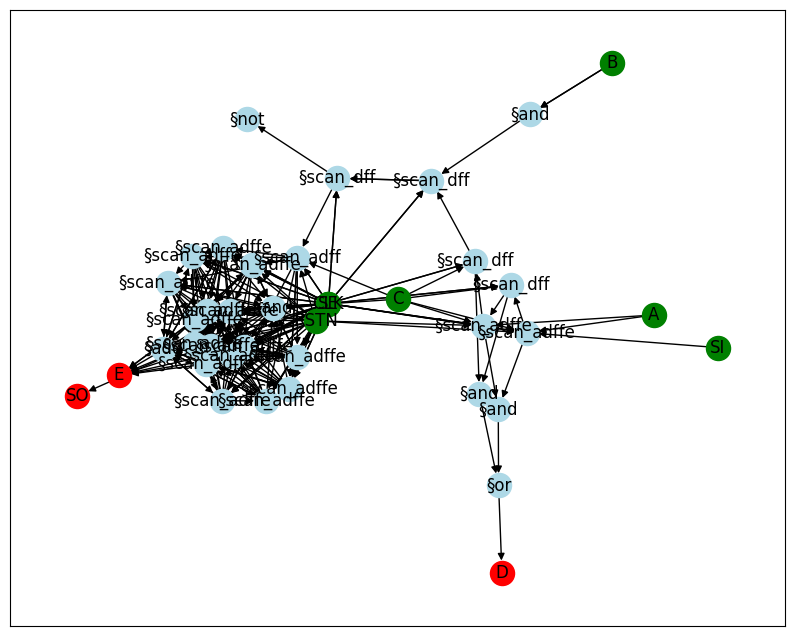

In [13]:
from netlist_carpentry.core.graph.visualization import Plotting

circuit.top.flatten(recursive=True)

p = Plotting(circuit.top.graph())
p.set_labels_default()
p.set_format("in", node_color="green")
p.set_format("out", node_color="red")
p.format_in_out(in_format="in", out_format="out")
p.show()